# Loading in Required Libraries

In [0]:
# Standard libraries/functions
import pandas as pd
import numpy as np
import seaborn as sns
import math
from datetime import datetime, timedelta
import holidays
import calendar
import matplotlib.pyplot as plt
# from dateutil.relativedelta import relativedelta


# Pyspark libraries/functions
import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf, count
from pyspark.sql.types import IntegerType, DateType, DoubleType, StringType, FloatType, BooleanType
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder, Imputer
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA
# from pyspark.sql import DataFrame

In [0]:
## library settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Setting Up Storage

In [0]:
## Place this cell in any team notebook that needs access to the team cloud storage.

# The following blob storage is accessible to team members only (read and write)
# access key is valid til TTL
# after that you will need to create a new SAS key and authenticate access again via DataBrick command line
blob_container  = "smsj-261"       # The name of your container created in https://portal.azure.com
storage_account = "smsj"  # The name of your Storage account created in https://portal.azure.com
secret_scope    = "smsjscope"           # The name of the scope created in your local computer using the Databricks CLI
secret_key      = "smsjkey"             # The name of the secret key created in your local computer using the Databricks CLI
team_blob_url        = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"  #points to the root of your team storage bucket

# the 261 course blob storage is mounted here on the DataBricks workspace.
mids261_mount_path      = "/mnt/mids-w261"

# SAS Token: Grant the team limited access to Azure Storage resources
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)
import pandas as pd
pdf = pd.DataFrame([[1, 2, 3, "Jane"], [2, 2,2, None], [12, 12,12, "John"]], columns=["x", "y", "z", "a_string"])
df = spark.createDataFrame(pdf) # Create a Spark dataframe from a pandas DF

# The following can write the dataframe to the team's Cloud Storage  
# Navigate back to your Storage account in https://portal.azure.com, to inspect the partitions/files.
# df.write.parquet(f"{team_blob_url}/test")

# see what's in the blob storage root folder 
display(dbutils.fs.ls(f"{team_blob_url}"))

path,name,size,modificationTime
wasbs://smsj-261@smsj.blob.core.windows.net/test/,test/,0,1689534418000


# Loading the Data

In [0]:
# LOADING 3 MONTH DATASET

# Handling OTPW_3M_2015.csv
df_main_3m = spark.read.option("header", "true").csv("dbfs:/mnt/mids-w261/OTPW_3M_2015.csv")

In [0]:
df_main_3m.printSchema()

root
 |-- QUARTER: string (nullable = true)
 |-- DAY_OF_MONTH: string (nullable = true)
 |-- DAY_OF_WEEK: string (nullable = true)
 |-- FL_DATE: string (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER_AIRLINE_ID: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN_AIRPORT_ID: string (nullable = true)
 |-- ORIGIN_AIRPORT_SEQ_ID: string (nullable = true)
 |-- ORIGIN_CITY_MARKET_ID: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY_NAME: string (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- ORIGIN_STATE_FIPS: string (nullable = true)
 |-- ORIGIN_STATE_NM: string (nullable = true)
 |-- ORIGIN_WAC: string (nullable = true)
 |-- DEST_AIRPORT_ID: string (nullable = true)
 |-- DEST_AIRPORT_SEQ_ID: string (nullable = true)
 |-- DEST_CITY_MARKET_ID: string (nullable = true)
 |-- DEST: string (nu

In [0]:
# LOADING 12 MONTH DATASET

# Handling OTPW_12W_2015.csv.gz
df_main_12m = spark.read.option("header", "true").option("compression", "gzip").csv("dbfs:/mnt/mids-w261/OTPW_12M/OTPW_12W_2015.csv.gz")

In [0]:
# LOADING 60 MONTH DATASET

paths = [
    "dbfs:/mnt/mids-w261/OTPW_60M/part-00000-tid-6348072830472745186-30cd655d-a41e-4b9e-8f85-ca9cebbfe25a-19-1-c000.csv.gz",
    "dbfs:/mnt/mids-w261/OTPW_60M/part-00001-tid-6348072830472745186-30cd655d-a41e-4b9e-8f85-ca9cebbfe25a-18-1-c000.csv.gz",
    "dbfs:/mnt/mids-w261/OTPW_60M/part-00002-tid-6348072830472745186-30cd655d-a41e-4b9e-8f85-ca9cebbfe25a-21-1-c000.csv.gz",
    "dbfs:/mnt/mids-w261/OTPW_60M/part-00003-tid-6348072830472745186-30cd655d-a41e-4b9e-8f85-ca9cebbfe25a-20-1-c000.csv.gz",
    "dbfs:/mnt/mids-w261/OTPW_60M/part-00004-tid-6348072830472745186-30cd655d-a41e-4b9e-8f85-ca9cebbfe25a-22-1-c000.csv.gz"
]

df = spark.read.format('csv').option("header","true").option("codec", "org.apache.hadoop.io.compress.GzipCodec").load(paths[0])
for path in paths[1:]:
    df_temp = spark.read.format('csv').option("header","true").option("codec", "org.apache.hadoop.io.compress.GzipCodec").load(path)
    df_main_60m = df.union(df_temp)

# 1. Feature Engineering

## 1.1 Choosing Relevant Features

In [0]:
# List all columns of original 3 months dataset
df_main_3m.columns

In [0]:
def subset_and_join_dataset(df_main, joint_columns):
    # Subsetted main dataset using relevant columns
    df_main_relevant = df_main.select(joint_columns)
    
    # Perform necessary joins with other datasets here if required
    # For example:
    # df_main_relevant = df_main_relevant.join(other_dataset, "join_column", "join_type")
    
    return df_main_relevant

# List of all features relevant to Flight Delays (as per our discretion) from each dataset
flight_columns = ["YEAR", "DAY_OF_WEEK", "FL_DATE", "CRS_DEP_TIME", "CRS_ARR_TIME", "DEP_TIME", 
                  "ARR_TIME", "DEP_DELAY", "ARR_DELAY", "CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", 
                  "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY", "TAXI_OUT", "TAXI_IN", "WHEELS_OFF", 
                  "WHEELS_ON", "AIR_TIME", "DISTANCE", "OP_CARRIER", "TAIL_NUM", "OP_CARRIER_FL_NUM",
                  "origin_airport_name", "dest_airport_name", "origin_airport_lat", "origin_airport_lon", 
                  "dest_airport_lat", "dest_airport_lon", "ORIGIN", "DEST", "CANCELLED"
                  ]

station_columns = ["origin_icao","LATITUDE","LONGITUDE"]

weather_columns = ["NAME","STATION","ELEVATION","SOURCE","REPORT_TYPE","HourlyWetBulbTemperature", 
                   "HourlyDryBulbTemperature", "HourlyDewPointTemperature", "HourlyRelativeHumidity",
                   "HourlySeaLevelPressure", "HourlyStationPressure", "HourlyWindSpeed", "HourlyWindDirection",
                   "HourlyPrecipitation", "HourlyVisibility", "HourlySkyConditions", "HourlyPresentWeatherType",
                   "HourlyAltimeterSetting","HourlyPressureChange", "HourlyWindGustSpeed", "DailyPeakWindSpeed",
                   "DailySnowDepth","DailySnowfall","DailySustainedWindSpeed", "DailyMaximumDryBulbTemperature",
                   "DailyMinimumDryBulbTemperature","DailyAverageRelativeHumidity"
                   ]

joint_columns = flight_columns + station_columns + weather_columns

In [0]:
# Call the function for each dataset
df_main_3m_relevant = subset_and_join_dataset(df_main_3m, joint_columns)

# df_main_12m_relevant = subset_and_join_dataset(df_main_12m, joint_columns)

# df_main_60m_relevant = subset_and_join_dataset(df_main_60m, joint_columns)

### 1.1a Data Type Conversion

In [0]:
def convert_column_types(input_df, coltype_map):
    """
    Converts the data types of columns in the DataFrame based on the coltype_map.
    input_df: The input DataFrame.
    coltype_map: A dictionary containing the mapping of column names to their desired data types.
    Returns the DataFrame with converted column types.
    """
    return input_df.select([F.col(c).cast(coltype_map[c]) if c in coltype_map.keys() else c for c in input_df.columns])


# Create type dictionary and convert all columns using the dictionary
coltype_map = {
    "DAY_OF_WEEK": IntegerType(),
    "FL_DATE": DateType(),
    "CRS_DEP_TIME": IntegerType(),
    "CRS_ARR_TIME": IntegerType(),
    "DEP_TIME": IntegerType(),
    "ARR_TIME": IntegerType(),
    "DEP_DELAY": DoubleType(),
    "ARR_DELAY": DoubleType(),
    "TAXI_OUT": DoubleType(),
    "TAXI_IN": DoubleType(),
    "AIR_TIME": DoubleType(),
    "origin_icao": StringType(),
    "LATITUDE": DoubleType(),
    "LONGITUDE": DoubleType(),
    "NAME": StringType(),
    "STATION": StringType(),
    "SOURCE": DoubleType(),
    "REPORT_TYPE": StringType(),
    "HourlyWetBulbTemperature": FloatType(),
    "HourlyWindSpeed": FloatType(),
    "HourlyWindDirection": FloatType(),
    "HourlyVisibility": FloatType(),
    "HourlyPresentWeatherType": FloatType(),
    "HourlySkyConditions": FloatType(),
    "HourlyRelativeHumidity": FloatType(),
    "HourlyPrecipitation": FloatType(),
    "HourlyDryBulbTemperature": FloatType(), ###
    "HourlyAltimeterSetting": FloatType(),
    "HourlyPressureChange": FloatType(),
    "HourlyWindGustSpeed": FloatType(),
    "DailyPeakWindSpeed": FloatType(),
    "DailySnowDepth": FloatType(),
    "DailySnowfall": FloatType(),
    "DailySustainedWindSpeed": FloatType(),
    "DailyMaximumDryBulbTemperature": FloatType(),
    "DailyMinimumDryBulbTemperature": FloatType(),
    "DailyAverageRelativeHumidity": FloatType(), ##
    "CARRIER_DELAY": FloatType(), 
    "WEATHER_DELAY": FloatType(), 
    "NAS_DELAY": FloatType(), 
    "SECURITY_DELAY": FloatType(),
    "LATE_AIRCRAFT_DELAY": FloatType(), 
    "YEAR": IntegerType(), 
    "ELEVATION": IntegerType(),
    "DISTANCE": IntegerType(),
    "CANCELLED": StringType()
}

# Convert column types in the main DataFrame
df_3m_dtype = convert_column_types(df_main_3m_relevant, coltype_map)
# df_12m_dtype = convert_column_types(df_main_12m_relevant, coltype_map)
# df_60m_dtype = convert_column_types(df_main_60m_relevant, coltype_map)

In [0]:
# # Print out the data type of each feature
# type_summary = {}
# for val in df_main.dtypes:
#     type_summary[val[0]] = val[1]
# type_df_post = pd.DataFrame(type_summary.items(), columns=['Feature Name', 'Data Type (After)'])

In [0]:
# # Type conversion summary
# type_df_final = type_df_pre.merge(type_df_post)
# type_df_final

## 1.2 Creating Features

In [0]:
def preprocess_data(input_df):
    """
    Performs feature engineering and preprocessing on the input DataFrame.

    Parameters:
    input_df (DataFrame): The input DataFrame containing the raw data.

    Returns:
    DataFrame: The preprocessed DataFrame with new features added.
    """
    # Convert 'FL_DATE' column to a proper date data type
    df_main = input_df.withColumn("FL_DATE", F.col("FL_DATE").cast("date"))

    # Feature 1: Creating new features departure time. Binning military time as dusk, dawn, daytime, and night.
    df_main.createOrReplaceTempView("tmp_main")
    df_main = spark.sql("""
        SELECT 
            CASE 
                WHEN DEP_TIME >= 1800 THEN 'Night' 
                WHEN DEP_TIME >= 1200 THEN 'Daytime' 
                WHEN DEP_TIME >= 600 THEN 'Dawn' 
                WHEN DEP_TIME >= 0 THEN 'Dusk'
                ELSE NULL 
            END AS flight_time_category, 
            * 
        FROM tmp_main
    """)



    # Feature 2: Full Flight Number
    df_main = df_main.withColumn('FLIGHT_NUM', F.concat(F.col('OP_CARRIER'), F.col('OP_CARRIER_FL_NUM')))



    # Feature 3: Categorize flight distance into bins
    df_main = df_main.withColumn("DISTANCE_BIN",
                                F.when(F.col("DISTANCE").cast("int") <= 500, "Short-Haul")
                                .when((F.col("DISTANCE").cast("int") > 500) & (F.col("DISTANCE").cast("int") <= 1500), "Medium-Haul")
                                .otherwise("Long-Haul"))



    # Feature 4: Categorize flight direction (Eastbound or Westbound) based on origin and destination airport coordinates
    def calculate_flight_direction(origin_lat, origin_lon, dest_lat, dest_lon):
        # Validate data types and handle missing or null values
        if None in [origin_lat, origin_lon, dest_lat, dest_lon]:
            return None
        if not all(isinstance(val, (int, float)) for val in [origin_lat, origin_lon, dest_lat, dest_lon]):
            return None

        # Convert degrees to radians
        lat1 = math.radians(origin_lat)
        lon1 = math.radians(origin_lon)
        lat2 = math.radians(dest_lat)
        lon2 = math.radians(dest_lon)

        # Calculate the difference in longitudes
        d_lon = lon2 - lon1

        # Calculate x and y components for the bearing
        x = math.cos(lat2) * math.sin(d_lon)
        y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)

        # Calculate the bearing (in degrees)
        bearing = math.degrees(math.atan2(x, y))

        # Convert bearing to a positive value
        if bearing < 0:
            bearing += 360

        # Categorize flights as Eastbound or Westbound
        return "Eastbound" if bearing <= 180 else "Westbound"

    calculate_flight_direction_udf = F.udf(calculate_flight_direction)

    df_main = df_main.withColumn("DIRECTION",
                                calculate_flight_direction_udf(
                                    F.col("origin_airport_lat"),
                                    F.col("origin_airport_lon"),
                                    F.col("dest_airport_lat"),
                                    F.col("dest_airport_lon")
                                ))



    # Feature 5: Calculate average delay by airline
    avg_delay_by_airline = df_main.groupBy("OP_CARRIER").avg("DEP_DELAY")
    df_main = df_main.join(avg_delay_by_airline, "OP_CARRIER", "left_outer") \
        .withColumnRenamed("avg(DEP_DELAY)", "AVG_DELAY_BY_AIRLINE")



    # Feature 6: Calculate average delay by day of the week
    avg_delay_by_day = df_main.groupBy("DAY_OF_WEEK").avg("DEP_DELAY")
    df_main = df_main.join(avg_delay_by_day, "DAY_OF_WEEK", "left_outer") \
        .withColumnRenamed("avg(DEP_DELAY)", "AVG_DELAY_BY_DAY_OF_WEEK")



    # Feature 7: Calculate average delay by route
    avg_delay_by_origin_dest = df_main.groupBy("ORIGIN", "DEST").avg("DEP_DELAY")
    df_main = df_main.join(avg_delay_by_origin_dest, ["ORIGIN", "DEST"], "left_outer") \
        .withColumnRenamed("avg(DEP_DELAY)", "AVG_DELAY_BY_ORIGIN_DEST")



    # Feature 8: Calculate flight frequency by airline and airport
    flight_frequency = df_main.groupBy("OP_CARRIER", "ORIGIN").count()
    df_main = df_main.join(flight_frequency, ["OP_CARRIER", "ORIGIN"], "left_outer") \
        .withColumnRenamed("count", "CARRIER_ORIGIN_AIRPORT_FLIGHT_FREQUENCY")



    # Feature 9: Count number of flights by origin and destination
    flight_count_by_origin_dest = df_main.groupBy("ORIGIN", "DEST").count()
    df_main = df_main.join(flight_count_by_origin_dest, ["ORIGIN", "DEST"], "left_outer") \
        .withColumnRenamed("count", "FLIGHT_COUNT_BY_ORIGIN_DEST")



    # Feature 10: Calculate delay ratio
    df_main = df_main.withColumn("FLIGHT_DURATION", F.col("CRS_ARR_TIME") - F.col("CRS_DEP_TIME"))
    df_main = df_main.withColumn("DELAY_RATIO", F.col("DEP_DELAY") / F.col("FLIGHT_DURATION"))



    # Feature 11: Calculate flight frequency by day of the week
    flight_frequency_by_day = df_main.groupBy("DAY_OF_WEEK").count()
    df_main = df_main.join(flight_frequency_by_day, "DAY_OF_WEEK", "left_outer") \
        .withColumnRenamed("count", "FLIGHT_FREQUENCY_BY_DAY")



    # Feature 12: Calculate the number of flights for each carrier in each direction
    direction_window = Window.partitionBy("OP_CARRIER", "DIRECTION")
    df_main = df_main.withColumn("FLIGHTS_BY_DIRECTION", F.count("*").over(direction_window))



    # Feature 13: Calculate the average distance of flights for each carrier in each direction
    df_main = df_main.withColumn("AVG_DISTANCE_BY_DIRECTION", F.avg("DISTANCE").over(direction_window))



    # Feature 14: Calculate the average air time of flights for each carrier in each direction
    df_main = df_main.withColumn("AVG_AIR_TIME_BY_DIRECTION", F.avg("AIR_TIME").over(direction_window))



    # Feature 15: Calculate the average delay ratio for each carrier in each direction
    df_main = df_main.withColumn("AVG_DELAY_RATIO_BY_DIRECTION", F.avg("DELAY_RATIO").over(direction_window))



    # Feature 16: Average, maximum, and minimum temperature during departure and arrival times
    window_by_origin_date = Window.partitionBy("ORIGIN", "FL_DATE")
    window_by_dest_date = Window.partitionBy("DEST", "FL_DATE")

    df_main = df_main.withColumn("DEPARTURE_TEMP", F.avg("HourlyDryBulbTemperature").over(window_by_origin_date))
    df_main = df_main.withColumn("ARRIVAL_TEMP", F.avg("HourlyDryBulbTemperature").over(window_by_dest_date))
    df_main = df_main.withColumn("DEP_MAX_TEMP", F.max("HourlyDryBulbTemperature").over(window_by_origin_date))
    df_main = df_main.withColumn("DEP_MIN_TEMP", F.min("HourlyDryBulbTemperature").over(window_by_origin_date))



    # Feature 17: Total precipitation amount during departure and arrival times
    df_main = df_main.withColumn("DEPARTURE_PRECIP", F.sum("HourlyPrecipitation").over(window_by_origin_date))
    df_main = df_main.withColumn("ARRIVAL_PRECIP", F.sum("HourlyPrecipitation").over(window_by_dest_date))



    # Feature 18: Average wind speed during departure and arrival times
    df_main = df_main.withColumn("DEPARTURE_WIND_SPEED", F.avg("HourlyWindSpeed").over(window_by_origin_date))
    df_main = df_main.withColumn("ARRIVAL_WIND_SPEED", F.avg("HourlyWindSpeed").over(window_by_dest_date))



    # Feature 19: Average visibility during departure and arrival times
    df_main = df_main.withColumn("DEPARTURE_VISIBILITY", F.avg("HourlyVisibility").over(window_by_origin_date))
    df_main = df_main.withColumn("ARRIVAL_VISIBILITY", F.avg("HourlyVisibility").over(window_by_dest_date))



    # Feature 20: Create binary field based on DEP_DELAY (1 if delayed, 0 otherwise)
    df_main.createOrReplaceTempView("tmp_main")
    df_main=spark.sql("select case when DEP_DELAY >= 15 then 1 else 0 end as model_delay, * from tmp_main")



    # Feature 21: Add a new column to the DataFrame with the cumulative sum of model_delay for each flight number
    flight_window_spec = Window.partitionBy("FLIGHT_NUM").orderBy("FL_DATE")
    df_main = df_main.withColumn("previous_flightnum_delay_ct", F.sum("model_delay").over(flight_window_spec))



    # Feature 22: Check if the flights took place on a U.S. holiday

    # Get the start and end years from your dataset (assuming the date column is "FL_DATE")
    start_year = df_main.selectExpr("min(FL_DATE) as min_date").collect()[0]["min_date"].year
    end_year = df_main.selectExpr("max(FL_DATE) as max_date").collect()[0]["max_date"].year

    # Generate the list of U.S. holidays for each year in the date range
    us_holidays = []
    for year in range(start_year, end_year + 1):
        us_holidays.extend(holidays.US(years=year).keys())

    # User-Defined Function to check if the date is a U.S. holiday
    # def is_us_holiday(flight_date):
    #     return flight_date in us_holidays
    def is_us_holiday(flight_date):
        return 1 if flight_date in us_holidays else 0
    # Register the UDF
    is_us_holiday_udf = F.udf(is_us_holiday, IntegerType())

    # Add the "is_us_holiday" column
    df_main = df_main.withColumn("us_holiday", is_us_holiday_udf(F.col("FL_DATE")))
    return df_main

# Call the function with your main DataFrame
df_3m_features = preprocess_data(df_3m_dtype)
# df_12m_features = preprocess_data(df_12m_dtype)
# df_60m_features = preprocess_data(df_60m_dtype)


In [0]:
# # FINDING UNITED'S MOST FREQUENTLY DELAYED FLIGHTS - NOT PART OF FEATURE ENGINEERING - SKIP
# UA_df_60m = df_60m_features.filter(col("OP_CARRIER") == "UA")
# delay_count_df_60m = UA_df_60m.filter(col("model_delay") == 1).groupBy("FLIGHT_NUM").agg(count("model_delay").alias("total_delays"))

In [0]:
# # FINDING UNITED'S MOST FREQUENTLY DELAYED FLIGHTS - NOT PART OF FEATURE ENGINEERING - SKIP
# delay_count_df_60m.display()

FLIGHT_NUM,total_delays
UA977,74
UA1574,104
UA1673,36
UA516,100
UA706,118
UA1446,54
UA323,61
UA1529,60
UA672,148
UA203,103


In [0]:
# FINDING UNITED'S TOP 5 FREQUENTLY DELAYED FLIGHTS AVERAGE DELAY TIME- NOT PART OF FEATURE ENGINEERING - SKIP

from pyspark.sql.functions import col, avg

# List of flight numbers you want to filter
flight_numbers = ["UA257", "UA1551", "UA599", "UA743", "UA711"]

# Filter the DataFrame based on the flight numbers and aggregate to calculate the average DEP_DELAY
average_dep_delay_df = df_60m_features.filter(col("FLIGHT_NUM").isin(flight_numbers)) \
                                     .groupBy("FLIGHT_NUM") \
                                     .agg(avg("DEP_DELAY").alias("avg_DEP_DELAY"))

# Show only 5 rows
average_dep_delay_df.display()

FLIGHT_NUM,avg_DEP_DELAY
UA1551,33.604
UA257,17.40450771055753
UA711,34.446486486486485
UA599,14.418965517241379
UA743,27.086918349429325


In [0]:
# # Graph Feature 1: Airport Connectivity - Number of direct flights from each airport to other airports
# airport_connectivity = df_main.groupBy("ORIGIN").agg(F.countDistinct("DEST").alias("AIRPORT_CONNECTIVITY"))
# df_main = df_main.join(airport_connectivity, "ORIGIN", "left_outer")

In [0]:
# # Graph Feature 2: Airport Degree Centrality - Measure the importance of an airport based on the number of connections it has
# airport_degree_centrality = df_main.groupBy("ORIGIN").agg(F.count("DEST").alias("AIRPORT_DEGREE_CENTRALITY"))
# df_main = df_main.join(airport_degree_centrality, "ORIGIN", "left_outer")

In [0]:
# # Graph Feature 3: Flight Density - Number of flights at each airport
# flight_density_window = Window.partitionBy("ORIGIN")
# df_main = df_main.withColumn("FLIGHT_DENSITY", F.count("*").over(flight_density_window))

In [0]:
# # Graph Feature 4: Flight Distance - Average flight distance from each airport
# flight_distance_window = Window.partitionBy("ORIGIN")
# df_main = df_main.withColumn("AVG_FLIGHT_DISTANCE", F.avg("DISTANCE").over(flight_distance_window))

In [0]:
# # Graph Feature 5: Flight Frequency by Airline - Calculate the frequency of flights for each airline
# flight_frequency_window = Window.partitionBy("OP_CARRIER")
# df_main = df_main.withColumn("FLIGHT_FREQUENCY_BY_AIRLINE", F.count("*").over(flight_frequency_window))

In [0]:
# CANCELLED Feature 23: Weather Conditions during departure and arrival times - DO NOT INCLUDE, NOT FINISHED
# Assuming you have a categorical column "WEATHER_CONDITION" indicating the weather conditions (e.g., clear, cloudy, rain, etc.)
# df_main = df_main.withColumn("DEPARTURE_WEATHER", F.first("WEATHER_CONDITION").over(Window.partitionBy("ORIGIN", "FL_DATE")))
# df_main = df_main.withColumn("ARRIVAL_WEATHER", F.first("WEATHER_CONDITION").over(Window.partitionBy("DEST", "FL_DATE")))



# CANCELLED Feature 24: Aircraft model - COULD NOT INCLUDE DUE TO API LIMITATIONS

# import requests
# from bs4 import BeautifulSoup
# from pyspark.sql.functions import udf
# from pyspark.sql.types import StringType

# # Function to get aircraft model from PlaneFinder website
# def get_aircraft_model(flight_number):
#     url = "https://planefinder.net/data/?q={}".format(flight_number)
#     response = requests.get(url)
#     soup = BeautifulSoup(response.content, "html.parser")
#     aircraft_element = soup.find("td", class_="data-aircraft")
#     if aircraft_element:
#         aircraft_model = aircraft_element.text.strip()
#     else:
#         aircraft_model = "Unknown"
#     return aircraft_model

# # User-Defined Function to get aircraft model
# get_aircraft_model_udf = udf(get_aircraft_model, StringType())

# # Filter DataFrame for distinct FLIGHT_NUM
# distinct_flight_numbers = df_main.select("FLIGHT_NUM").distinct()

# # Create a list of distinct flight numbers
# flight_numbers_list = [row["FLIGHT_NUM"] for row in distinct_flight_numbers.collect()]

# # Use the list of distinct flight numbers to call the API and get the aircraft models
# aircraft_models = []
# for flight_number in flight_numbers_list:
#     aircraft_model = get_aircraft_model(flight_number)
#     aircraft_models.append(aircraft_model)

# # Create a new column in the DataFrame called aircraft_model
# df_main = df_main.withColumn("aircraft_model", get_aircraft_model_udf(F.col("FLIGHT_NUM")))

In [0]:
# CANCELLED Graph Feature 6: Airport Betweenness Centrality to Identify critical hubs connecting other airports - TIMES OUT CRASHES NOTEBOOK 

# # Step 1: Filter the DataFrame to select the airports you want to analyze
# top_n = 10  # Replace this with the number of top airports you want to analyze
# airport_connectivity_window = Window.orderBy(F.desc("AIRPORT_CONNECTIVITY"))
# filtered_df = df_main.withColumn("rank", F.rank().over(airport_connectivity_window))
# filtered_df = filtered_df.where(F.col("rank") <= top_n).drop("rank")

# # Step 2: Create a graph representation and cache it
# edges = filtered_df.select(F.col("ORIGIN").alias("src"), F.col("DEST").alias("dst"))
# vertices = edges.select(F.col("src").alias("id")).union(edges.select(F.col("dst").alias("id"))).distinct()
# flight_graph = GraphFrame(vertices, edges)

# # Cache the graph in memory to avoid recomputation
# flight_graph.cache()

# # Step 3: Calculate Pagerank scores
# pagerank_result = flight_graph.pageRank(resetProbability=0.15, maxIter=10)

# # Unpersist the cached DataFrame if you don't need it anymore
# flight_graph.unpersist()

# # Step 4: Calculate Airport Betweenness Centrality using the Pagerank scores
# airport_betweenness_centrality = pagerank_result.vertices.select("id", "pagerank").withColumnRenamed("id", "ORIGIN")

# # Step 5: Join the calculated Airport Betweenness Centrality to your main DataFrame
# df_main = df_main.join(airport_betweenness_centrality, "ORIGIN", "left_outer")

# 2. Model Pipeline

## 2.1 Null Handling

In [0]:
# ## Dropped columns with count(null) > 1 million
def null_handling (df_input, drop_features):
    df_drop = df_input.drop(*drop_features)
    return df_drop

null_features_3m = ["HourlyPresentWeatherType", "CANCELLATION_CODE", "CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY","LATE_AIRCRAFT_DELAY", "YEAR", "ELEVATION", "HourlySkyConditions",]
null_features_12m = ["DIRECTION", "HourlySeaLevelPressure"]

df_3m_na = null_handling (df_3m_features, null_features_3m)
# df_12m_na = null_handling (df_12m_features, null_features_12m)
# df_60m_na = null_handling (df_60m_features, null_features_12m)

In [0]:
# Get null counts of df_main dataset before we dropping the features with null values greater than one million
column_names = df_3m_na.columns
df_nan = df_3m_na.select(*[
    F.sum(F.col(col_name).isNull().cast("int")).alias(col_name)
    for col_name in column_names
]).toPandas().T.reset_index()
df_nan = df_nan.rename(columns={"index": "Feature Name", 0: "Pre-Drop Null Count"})
display(df_nan)

Feature Name,Pre-Drop Null Count
model_delay,0
DAY_OF_WEEK,0
ORIGIN,0
DEST,0
OP_CARRIER,0
flight_time_category,42306
FL_DATE,0
CRS_DEP_TIME,0
CRS_ARR_TIME,0
DEP_TIME,42306


In [0]:
# # Get null counts of df_main dataset before we dropping the features with null values greater than one million
# column_names = df_60m_na.columns
# df_nan = df_60m_na.select(*[
#     F.sum(F.col(col_name).isNull().cast("int")).alias(col_name)
#     for col_name in column_names
# ]).toPandas().T.reset_index()
# df_nan = df_nan.rename(columns={"index": "Feature Name", 0: "Pre-Drop Null Count"})
# display(df_nan)

In [0]:
# if False:

#     # Verify all nulls were dropped
#     df_nan_post = df_main_nan.select(*[
#         F.sum(F.col(col_name).isNull().cast("int")).alias(col_name)
#         for col_name in column_names
#     ]).toPandas().T.reset_index()
#     df_nan_post = df_nan_post.rename(columns={"index": "Feature Name", 0: "Post-Drop Null Count"})

In [0]:
# if False:

#     ## Combine Null Count Tables
#     null_summary = df_nan_pre.merge(df_nan, 'outer')

## 2.2 Feature EDA

In [0]:
# Creating a correlation matrix
def get_corr_matrix(dataset, min_corr = 0, figsize_x = 15, figsize_y = 10, labelfontsize = 5, tickfontsize = 10, rotation = 0, title = 'Correlation Matrix'):
    '''
    Description: This function creates a correlation matrix using the dataset provided
    Input: Dataset, minimum correlation value, label font size, tick font size, graph title
    Output: Correlation matrix
    '''
    # Verify input
    if min_corr > 1 or min_corr < 0:
        raise Exception("Invalid correlation value, please enter a decimal value in between 0 and 1")

    if figsize_x < 0 or figsize_y < 0:
        raise Exception("Invalid figure size(s), please enter a value greater than 0")

    if labelfontsize < 0 or tickfontsize < 0:
        raise Exception("Invalid font size(s), please enter a value greater than 0")
    
    if rotation < 0 or rotation > 360:
            raise Exception("Invalid rotation value, please enter a value between 0 and 360")

    # Initialize values
    min_corr = min_corr
    fig_x = figsize_x
    fig_y = figsize_y
    label_size = labelfontsize
    tick_size = tickfontsize
    rot_val = rotation
    plot_title = title

    # Grabbing all numeric columns from dataset
    numeric_columns = [column for column, dtype in dataset.dtypes if dtype in ['int', 'float', 'double']]
    df_numeric = dataset.select(numeric_columns)
    pandas_df = df_numeric.toPandas()

    # Drop year and quarter if they exist
    if 'QUARTER' in pandas_df.columns:
        pandas_df = pandas_df.drop(['QUARTER'], axis = 1)
    if 'YEAR' in pandas_df.columns:
        pandas_df = pandas_df.drop(['YEAR'], axis = 1)

    # Create the correlation matrix
    correlation_matrix = pandas_df.corr()

    # Filter correlation matrix based on the minimum required correlation
    if min_corr == 0:
        new_corr = correlation_matrix
    else:
        arr_delay_corr = correlation_matrix[correlation_matrix >= min_corr]
        new_corr = pandas_df[arr_delay_corr.index].corr()

    # Create the heatmap
    plt.figure(figsize=(fig_x, fig_y))  # Set the size of the heatmap

    mask = np.tril(np.ones_like(new_corr, dtype=bool))
    sns.heatmap(new_corr, annot=False, cmap="coolwarm", linewidths=1, mask=~mask)  # Apply the mask to show only the bottom half

    x_tick_center = [i + 0.5 for i in range(len(new_corr.columns))]
    y_tick_center = [i + 0.5 for i in range(len(new_corr.columns))]

    # Set the tick positions and labels
    plt.xticks(x_tick_center, new_corr.columns, fontsize=tick_size, ha='center')
    plt.yticks(y_tick_center, new_corr.columns, fontsize=tick_size, va='center')
    plt.xlabel("Features", fontsize = label_size)
    plt.ylabel("Features", fontsize = label_size)
    plt.title(plot_title)
    if rot_val != 0:
        plt.xticks(rotation = rot_val, ha = 'right')

    # Display the heatmap
    plt.show()
    # return correlation_matrix


In [0]:
column_data_types = df_3m_na.dtypes

# Filter columns that are not categorical (i.e., numeric columns)
non_categorical_columns = [col_name for col_name, col_type in column_data_types if col_type not in ['string', 'date']]


In [0]:
# TEST FOR EDA
non_pca_num = ["AIR_TIME", "HourlyWindSpeed", "HourlyDryBulbTemperature","HourlyVisibility", "HourlyWindDirection", "previous_flightnum_delay_ct"]
pca_num = ['HourlyWetBulbTemperature','DISTANCE','HourlyRelativeHumidity', 'HourlyPrecipitation', 
            "HourlyAltimeterSetting","HourlyPressureChange", "HourlyWindGustSpeed", "DailyPeakWindSpeed",
            "DailySnowDepth","DailySnowfall","DailySustainedWindSpeed", "DailyMaximumDryBulbTemperature",
            "DailyMinimumDryBulbTemperature","DailyAverageRelativeHumidity"]

all_numerics = non_categorical_columns
imputers = Imputer(inputCols=all_numerics, outputCols=all_numerics)
pipeline = Pipeline(stages = [imputers])
yolo = pipeline.fit(df_3m_na)
df_3m_eda = yolo.transform(df_3m_na)

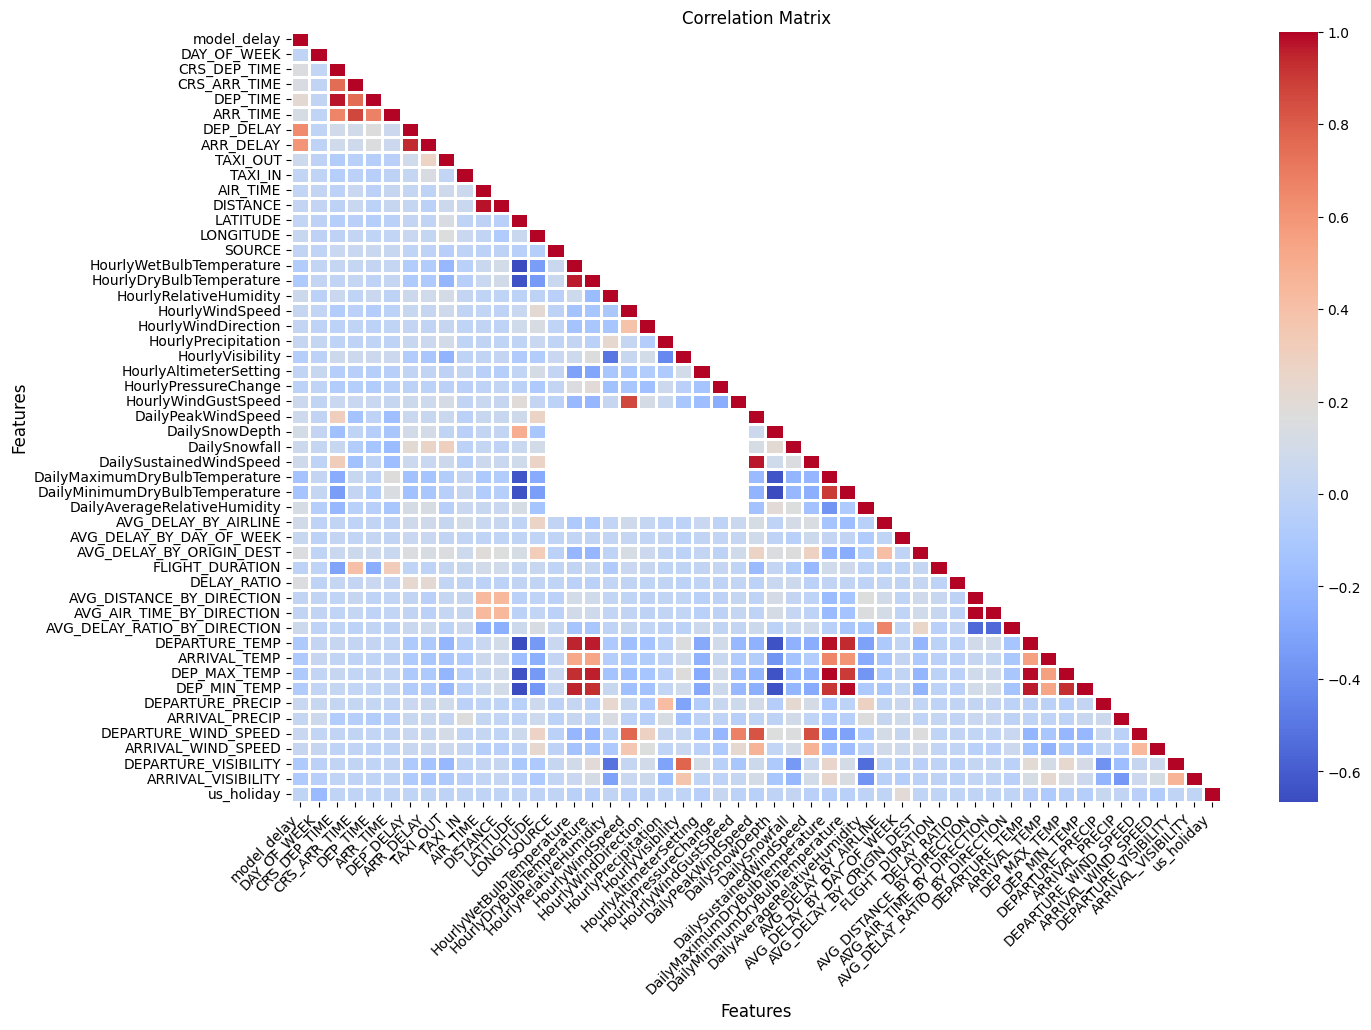

In [0]:
get_corr_matrix(df_3m_na, min_corr = 0, figsize_x = 15, figsize_y = 10, labelfontsize = 12, tickfontsize = 10, rotation = 45, title = 'Correlation Matrix')

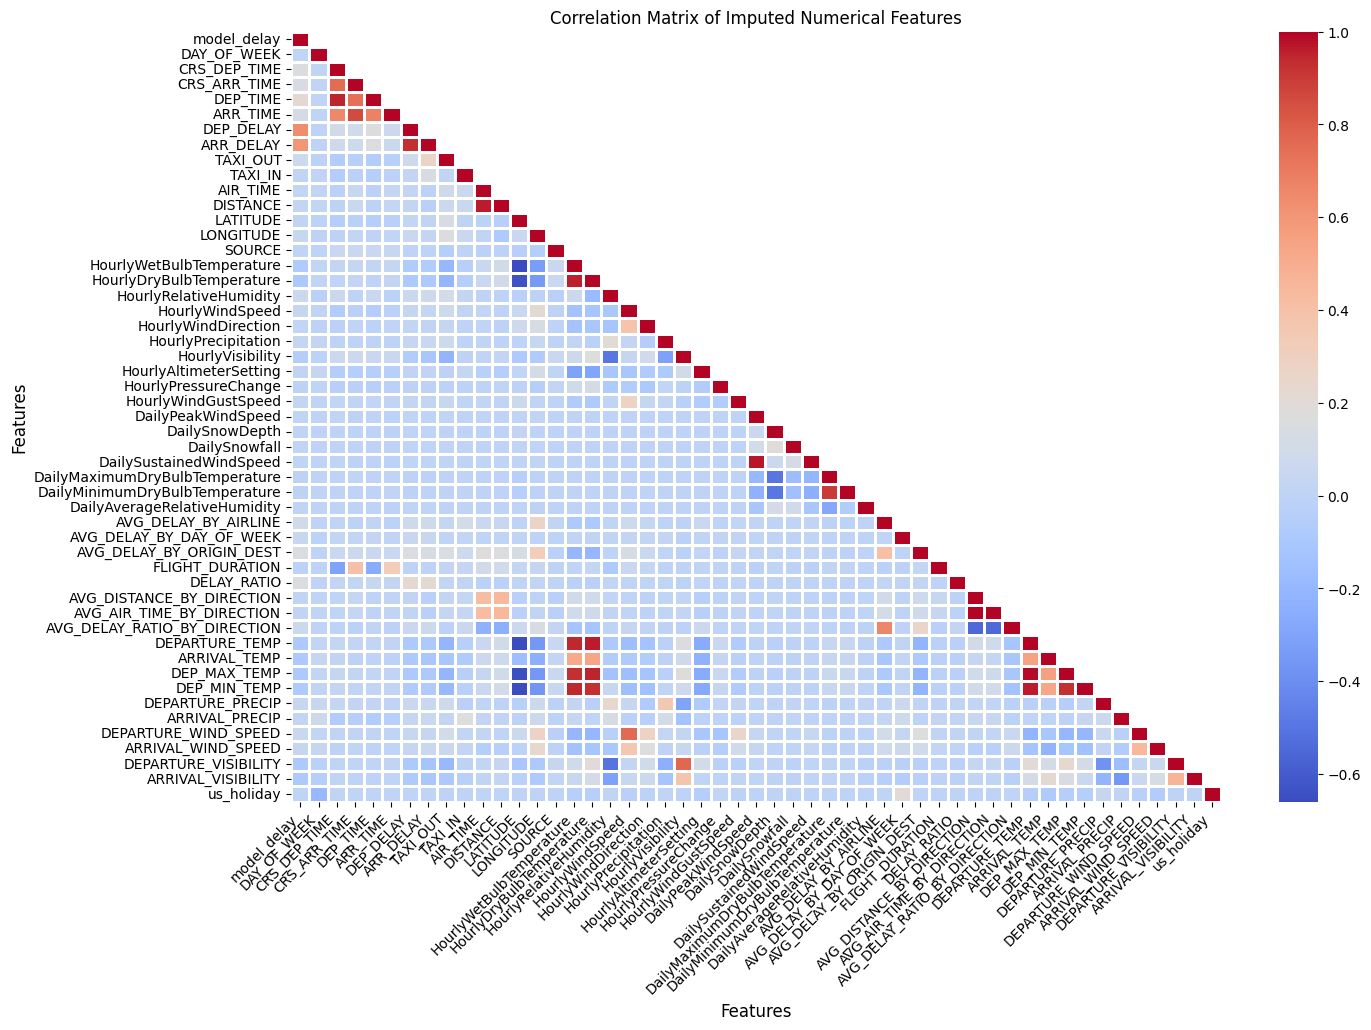

In [0]:
get_corr_matrix(df_3m_eda, min_corr = 0, figsize_x = 15, figsize_y = 10, labelfontsize = 12, tickfontsize = 10, rotation = 45, title = 'Correlation Matrix of Imputed Numerical Features')

## 2.2 Impute Categorical Features & One Hot Coding

In [0]:
def impute_categoricals(df, categoricals_list, unknown_flag):
    '''
    Description:
    Input:
    Output:
    '''
    # Fill each column's null values with the mode
    for categorical_feature in categoricals_list:   
        output_df = df.na.fill('unknown',[categorical_feature])
    return output_df

In [0]:
def OneHot_Pipeline(impute_df, input_categoricals_columns):
    '''
    Description: This function applies one-hot encoding to the categorical columns and creates a pipeline, which is then fitted against the imputed dataframe
    Input: Imputed dataset (categorical only) and list of categorical columns
    Output: Dataset with one-hot encoding after this
    '''

    # Running indexer and one hot encoding on passed in categorical
    indexers = map(lambda c: StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid = 'keep'), input_categoricals_columns)
    ohes = map(lambda c: OneHotEncoder(inputCol=c + "_idx", outputCol=c+"_class"), input_categoricals_columns)

    # Establish features columns
    model_matrix_stages =  list(indexers) + list(ohes) 

    # Create pipeline and then transform it into a dataset
    pipeline = Pipeline (stages=model_matrix_stages)
    OneHot_pipeline = pipeline.fit(impute_df)
    OneHot_df = OneHot_pipeline.transform(impute_df)

    return OneHot_df
    

In [0]:
# param_dict = {}
# input_categoricals = ["REPORT_TYPE","DAY_OF_WEEK","flight_time_category"]
# non_pca_num = ["AIR_TIME", "HourlyWindSpeed", "HourlyDryBulbTemperature","HourlyVisibility", "HourlyWindDirection", "previous_flightnum_delay_ct"]
# pca_num = ['HourlyWetBulbTemperature','DISTANCE','HourlyRelativeHumidity', 'HourlyPrecipitation']

In [0]:
# 3 months one hot encoding
# drop report type
cat_features = [#"REPORT_TYPE",
                "DAY_OF_WEEK","flight_time_category", "DISTANCE_BIN", "CANCELLED", "us_holiday"]

df_3m_impute = impute_categoricals(df_3m_na, cat_features, False)
df_3m_oneHot = OneHot_Pipeline(df_3m_impute, cat_features)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-3984215836272232>:5
      1 # 3 months one hot encoding
      2 cat_features = [#"REPORT_TYPE",
      3                 "DAY_OF_WEEK","flight_time_category", "DISTANCE_BIN", "CANCELLED", "us_holiday"]
----> 5 df_3m_impute = impute_categoricals(df_3m_na, cat_features, False)
      6 df_3m_oneHot = OneHot_Pipeline(df_3m_impute, cat_features)

NameError: name 'impute_categoricals' is not defined

In [0]:
# 12 months one hot encoding

df_12m_impute = impute_categoricals(df_12m_na, cat_features, False)
df_12m_oneHot = OneHot_Pipeline(df_12m_impute, cat_features)

In [0]:
# 60 months one hot encoding

df_60m_impute = impute_categoricals(df_60m_na, cat_features, False)
df_60m_oneHot = OneHot_Pipeline(df_60m_impute, cat_features)

# 3. Split Training and Testing Set

In [0]:
from pyspark.sql.functions import col, year, month

# Creating new DF for splits
df_3m_with_year_month = df_3m_oneHot.withColumn("Year", year("FL_DATE")).withColumn("Month", month("FL_DATE"))
df_12m_with_year_month = df_12m_oneHot.withColumn("Year", year("FL_DATE")).withColumn("Month", month("FL_DATE"))
df_60m_with_year_month = df_60m_oneHot.withColumn("Year", year("FL_DATE")).withColumn("Month", month("FL_DATE"))

# Filter the DataFrame to create the training set
training_3m = df_3m_with_year_month.filter((df_3m_with_year_month["Year"] < 2015) | 
                                           ((df_3m_with_year_month["Year"] == 2015) & 
                                            (df_3m_with_year_month["Month"] < 3)))
# Filter the DataFrame to create the testing set
testing_3m = df_3m_with_year_month.filter((df_3m_with_year_month["Year"] == 2015) & 
                                          (df_3m_with_year_month["Month"] >= 3))

# Filter the DataFrame to create the training set
training_12m = df_12m_with_year_month.filter(df_12m_with_year_month["Month"] <= 8)
# Filter the DataFrame to create the testing set
testing_12m = df_12m_with_year_month.filter(df_12m_with_year_month["Month"] > 8)

# Filter the DataFrame to create the training set
training_60m = df_60m_with_year_month.filter((df_60m_with_year_month["Year"] <= 2018))
# Filter the DataFrame to create the testing set
testing_60m = df_60m_with_year_month.filter((df_60m_with_year_month["Year"] > 2018))


# 4. Standard Scaler

In [0]:
def StandardScaler_Pipeline(non_pca_columns, pca_columns):
    '''
    Description: This function applies one-hot encoding to the categorical columns and creates a pipeline, which is then fitted against the imputed dataframe
    Input: Imputed dataset (categorical only) and list of categorical columns
    Output: Dataset with one-hot encoding after this
    '''

    # VectorAssembler
    
    all_numerics = non_pca_columns+ pca_columns

    imputers = Imputer(inputCols=all_numerics, outputCols=all_numerics)

    assembler_numeric_non_pca = VectorAssembler( inputCols=non_pca_columns, outputCol='numeric_non_pca_pre_scale')

    assembler_numeric_pca = VectorAssembler( inputCols=pca_columns, outputCol='numeric_pca_pre_scale')
    

    numeric_scaler_non_pca = StandardScaler(inputCol='numeric_non_pca_pre_scale',
                            outputCol="numeric_scaled_non_pca",
                            withStd=True,
                            withMean=True)
    
    numeric_scaler_pca = StandardScaler(inputCol= 'numeric_pca_pre_scale',
                            outputCol="numeric_scaled_pca",
                            withStd=True,
                            withMean=True)


    model_matrix_stages = [imputers ] + \
                            [assembler_numeric_non_pca] + \
                            [assembler_numeric_pca] + \
                            [numeric_scaler_non_pca] + [numeric_scaler_pca]

    return model_matrix_stages


non_pca_num = ["AIR_TIME", "HourlyWindSpeed", "HourlyDryBulbTemperature","HourlyVisibility", "HourlyWindDirection", "previous_flightnum_delay_ct"]
pca_num = ['HourlyWetBulbTemperature','DISTANCE','HourlyRelativeHumidity', 'HourlyPrecipitation', 
            "HourlyAltimeterSetting","HourlyPressureChange", "HourlyWindGustSpeed", "DailyPeakWindSpeed",
            "DailySnowDepth","DailySnowfall","DailySustainedWindSpeed", "DailyMaximumDryBulbTemperature",
            "DailyMinimumDryBulbTemperature","DailyAverageRelativeHumidity"]

test_scaler_pipeline = StandardScaler_Pipeline(non_pca_num, pca_num)
# Create pipeline and then transform it into a dataset
# pipeline = Pipeline(stages=test_scaler_pipeline)
# scaled_pipeline = pipeline.fit(training_3m)
# scaled_pipeline_output = scaled_pipeline.transform(training_3m)


# 5. PCA

In [0]:
def PCA_Pipeline(k):

    pca = PCA(k=k, inputCol='numeric_scaled_pca', outputCol='dense_vect_pca_features')
    model_matrix_stages = [pca]

    return model_matrix_stages
    
test_PCA_pipeline = PCA_Pipeline(7)
# Create pipeline and then transform it into a dataset
# pipeline = Pipeline(stages=test_PCA_pipeline)
# PCA_pipeline = pipeline.fit(scaled_pipeline_output)
# PCA_pipeline_output = PCA_pipeline.transform(scaled_pipeline_output)



# 6. Final Assembler

In [0]:
def Final_Assembler_Pipeline(categoricals_columns, pred_col):

    categoricals = list(map(lambda c: c+"_class", categoricals_columns))

    assemblerAll = VectorAssembler(inputCols= ["numeric_scaled_non_pca", "dense_vect_pca_features"] +categoricals , outputCol="allFeatures")
    label = StringIndexer(inputCol=pred_col, outputCol="label")
    model_matrix_stages = [assemblerAll] + [label]

    return model_matrix_stages
    
test_Final_Assembler_pipeline = Final_Assembler_Pipeline(cat_features, "model_delay")
# Create pipeline and then transform it into a dataset
# pipeline = Pipeline(stages=test_Final_Assembler_pipeline)
# Final_Assembler_pipeline = pipeline.fit(PCA_pipeline_output)
# Final_Assembler_pipeline_output = Final_Assembler_pipeline.transform(PCA_pipeline_output)

In [0]:
# Creating Final Assember Pipeline
pipeline = Pipeline(stages=test_scaler_pipeline + test_PCA_pipeline + test_Final_Assembler_pipeline)

# Pipeline 3M
pipeline_full_3m = pipeline.fit(training_3m)

# Pipeline 12M
pipeline_full_12m = pipeline.fit(training_12m)

# Pipeline 60M
pipeline_full_60m = pipeline.fit(training_60m)

In [0]:
# 3M Tranformation
training_3m_transformed = pipeline_full_3m.transform(training_3m)
testing_3m_transformed = pipeline_full_3m.transform(testing_3m)

# 12M Tranformation
training_12m_transformed = pipeline_full_12m.transform(training_12m)
testing_12m_transformed = pipeline_full_12m.transform(testing_12m)

# 60M Tranformation
training_60m_transformed = pipeline_full_60m.transform(training_60m)
testing_60m_transformed = pipeline_full_60m.transform(testing_60m)

In [0]:
# Writing 3M DF as a table in Parquet format
testing_3m_transformed.write.mode("overwrite").format("parquet").saveAsTable("test_3m")
training_3m_transformed.write.mode("overwrite").format("parquet").saveAsTable("train_3m")

In [0]:
# Writing 12M DF as a table in Parquet format
testing_12m_transformed.write.mode("overwrite").format("parquet").saveAsTable("test_12m")
training_12m_transformed.write.mode("overwrite").format("parquet").saveAsTable("train_12m")

In [0]:
# Writing 60M DF as a table in Parquet format
testing_60m_transformed.write.mode("overwrite").format("parquet").saveAsTable("test_60m")
training_60m_transformed.write.mode("overwrite").format("parquet").saveAsTable("train_60m")

In [0]:
from hyperopt import fmin, tpe, Trials
import mlflow

mlflow.pyspark.ml.autolog(log_models=False)

In [0]:
testing_60m_transformed